In [1]:
%run -i "loaddata.py"
plt.rcParams["font.size"] = 13
import scipy.stats as st
import xgboost as xgb

What is your name? [Simone/Jonathan/Marcus/Runi]Jonathan


# Try to include the previous RVS value as parameter

In [2]:
# Collect remove nan and collect into 4 lists
keys = tuple(data_dict.keys())[::2]

data4 = []
for key in keys:
    part = []
    for vec in list(data_dict[key]):
        if not np.isnan(vec[0]):
            part.append(list(vec))
    data4.append(part)

features = data_dict[ list(data_dict.keys())[1] ]

In [3]:
# Append the RVS value from previous timestamp
data_time4 = []
for arr in data4:
    part = []
    for i in range(1, len(arr)):
        vec = arr[i].copy()
        vec.append( arr[i-1][1] )
        part.append( vec )
    data_time4.append(np.array(part))

## Predict on 1 timeseries from other 3

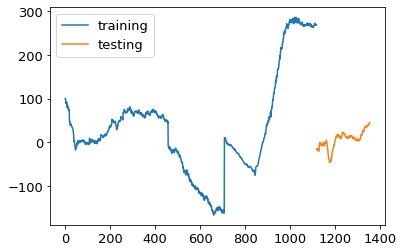

In [4]:
# Choose which timeseries to test on
ind_test = 2

# Make new test and train
keyss = [keys[i] for i in range(4) if i!=ind_test]

train = []
for i in range(4):
    if i!=ind_test:
        for vec in data_time4[i]:
            train.append(vec)
train = np.array(train)

test = np.copy( data_time4[ind_test] )

X_train, y_train = np.copy(train[:,3:]), np.copy(train[:,1])
X_test, y_test = np.copy(test[:,3:]), np.copy(test[:,1])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

### XGBoost using true value of prior data point

In [40]:
model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

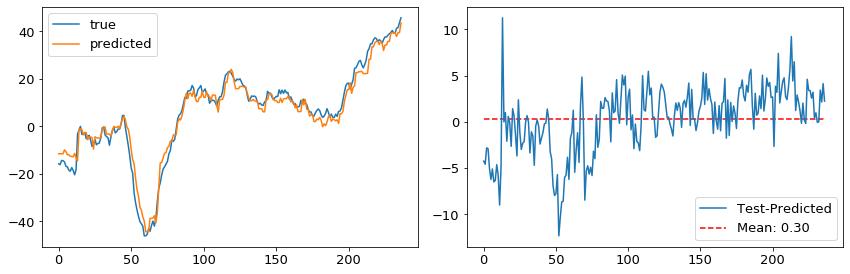

RMS = 3.576


In [42]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()

plt.subplot(122)
diff = y_test-y_pred
plt.plot(diff, label='Test-Predicted')
plt.hlines(np.mean(diff), 0, len(diff), ls='--', color='r', label=f"Mean: {np.mean(diff):.2f}")
plt.legend()

plt.tight_layout()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

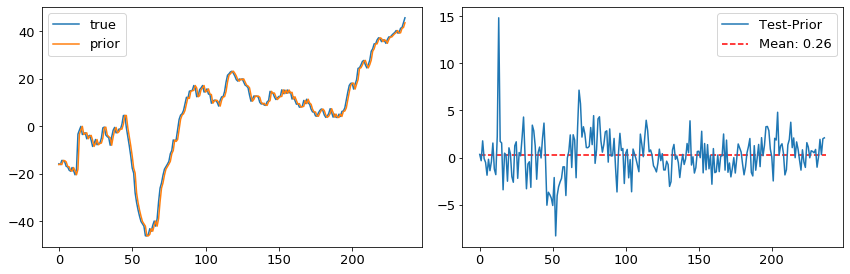

RMS = 2.266


In [44]:
# Try by simply subtracting the prior datapoint (no machine learning)
prior = X_test[:,-1]

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(y_test,label="true")
plt.plot(prior, label="prior")
plt.legend()

plt.subplot(122)
diff = y_test-prior
plt.plot(diff, label='Test-Prior')
plt.hlines(np.mean(diff), 0, len(diff), ls='--', color='r', label=f"Mean: {np.mean(diff):.2f}")
plt.legend()

plt.tight_layout()
plt.show()

rms = np.sqrt(np.sum((y_test-prior)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### XGBoost using predicted value of prior data point

In [33]:
y_pred = []

# Start using the true prior point
params = np.reshape( X_test[0], (1, len(X_test[0])) )
y_pred.append( model.predict(params)[0] )

# Iterate predictions using prior predicted point
for i in range(len(X_test)-1):
    params =  np.reshape( np.append(X_test[i,:-1], params[0][-1]), (1, len(X_test[i])) )
    y_pred.append( model.predict(params)[0] )

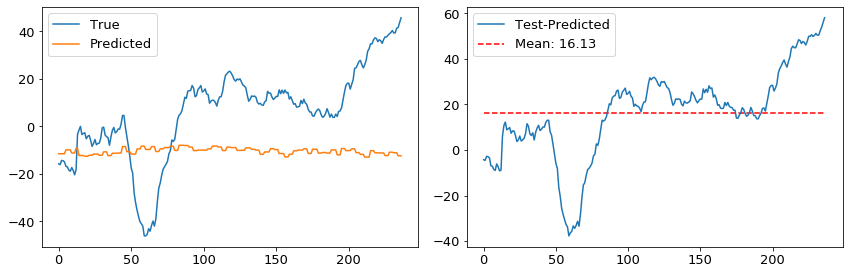

RMS = 25.409


In [38]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(y_test,label="True")
plt.plot(y_pred, label="Predicted")
plt.legend()

plt.subplot(122)
diff = y_test-y_pred
plt.plot(diff, label='Test-Predicted')
plt.hlines(np.mean(diff), 0, len(diff), ls='--', color='r', label=f"Mean: {np.mean(diff):.2f}")
plt.legend()

plt.tight_layout()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")